Enrico Lupi 2090596

# Bayesian Blocks Algorithm

In [38]:
library(tidyverse)

Warning message:
"package 'tidyverse' was built under R version 4.2.3"


Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
Warning message:
"package 'lubridate' was built under R version 4.2.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<ht

In [61]:
bayesian_blocks <- function(data,
                            weights = NULL,
                            Prior = "calibrated",
                            p0 = 0.05,
                            gamma = NULL) {
    # Bayesian Blocks Implementation.

    # This is a flexible implementation of the Bayesian Blocks algorithm for 1 dimesion.

    # Args:
    #   data: Input data values (one dimensional, length N). Repeat values are allowed.

    #   weights: Weights for data (otherwise assume all data points have a weight of 1).
    #            Must be same length as data. Defaults to NULL.

    #   prior: Prior on the number of blocks. Options include a uniform prior, a gemetric prior that
    #          penalizes an excessive number of blocks and a calibrated prior in order to achieve the
    #          specified false-positive rate p0. Deafults to the calibrated one 

    #   p0: False-positive rate, between 0 and 1. A lower number places a stricter penalty
    #       against creating more bin edges, thus reducing the potential for false-positive bin edges. In general,
    #       the larger the number of bins, the small the p0 should be to prevent the creation of spurious, jagged
    #       bins. Defaults to 0.05.

    #   gamma: If specified, then use this gamma to compute the general prior form,
    #          p = gamma^N. If gamma is specified, p0 is ignored. Defaults to NULL.

    # Returns:
    #   Array containing the (N+1) bin edges

    # Examples:
    #   Unweighted data:

    #   >>> d <- rnorm(n=100)
    #   >>> bins <- bayesian_blocks(d, p0=0.01)

    #   Unweighted data with repeats:

    #   >>> d <- rnorm(n=100)
    #   >>> d[81:100] <- d[1:20]
    #   >>> bins <- bayesian_blocks(d, p0=0.01)

    #   Weighted data:

    #   >>> d <- rnorm(n=100)
    #   >>> w <- runif(n=100, min=1, max=2)
    #   >>> bins <- bayesian_blocks(d, w, p0=0.01)

    
    # validate input data
    data <- as.vector(data)

    # validate input weights
    if (!is.null(weights)) {
        weights <- as.vector(weights)
    }
    else {
        # set them to 1 if not given
        weights <- rep(1, length(data))
    }

    # Place data and weights into a DataFrame.
    # We want to sort the data array (without losing the associated weights), and combine duplicate
    # data points by summing their weights together.
    df <- data.frame(data = data, weights = weights) |>
          group_by(data) |>
          summarise(sum_w = sum(weights))
    data <- pull(df, data)
    weights <- pull(df, sum_w)

    N = length(data)


    # create length-(N + 1) array of cell edges
    edges <- c(data[1], 0.5 * (data[1:(N-1)] + data[2:N]), data[N])
    block_length = data[N] - edges


    # arrays to store the best configuration
    best <- rep(0, N)
    last <- rep(0, N)


    # -----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    # -----------------------------------------------------------------
    
    for (R in 1:N) {
        # Compute fit_vec : fitness of putative last block (end at R)

        # T_k: width/duration of each block
        T_k <- block_length[1:R] - block_length[R+1]

        # N_k: number of elements in each block
        N_k <- rev(cumsum(rev(weights[1:R])))

        # evaluate fitness function using Cash statistics
        fit_vec <- N_k * log(N_k / T_k)

        # penalize function with prior
        prior <- switch(Prior, 
                        "uniform" = 0,
                        "gamma" = -log(gamma),
                        "calibrated" = 4 - log(73.53 * p0 * R**(-0.478)),
                        0 # default case
                 )
        A_R <- fit_vec - prior
        A_R[2:R] <- A_R[2:R] + best[1:(R-1)]

        i_max = which.max(A_R)
        last[R] = i_max
        best[R] = A_R[i_max]
    }

    # -----------------------------------------------------------------
    # Now find changepoints by iteratively peeling off the last block
    # -----------------------------------------------------------------

    change_points = rep(0, N)
    i_cp = N + 1
    ind = N + 1
    repeat {
        i_cp <- i_cp - 1
        change_points[i_cp] <- ind
        if(ind == 1) {
            break
        }
        ind <- last[ind-1]
    }
    change_points = change_points[i_cp:N]

    return(edges[change_points])
}

Test 

In [65]:
norm_data <- c(rnorm(20000,0,0.8),rnorm(40000,5,0.7),rnorm(40000,7,0.5))
N <- length(norm_data)
breaks = bayesian_blocks(norm_data, Prior="calibrated", p0 = 0.05)

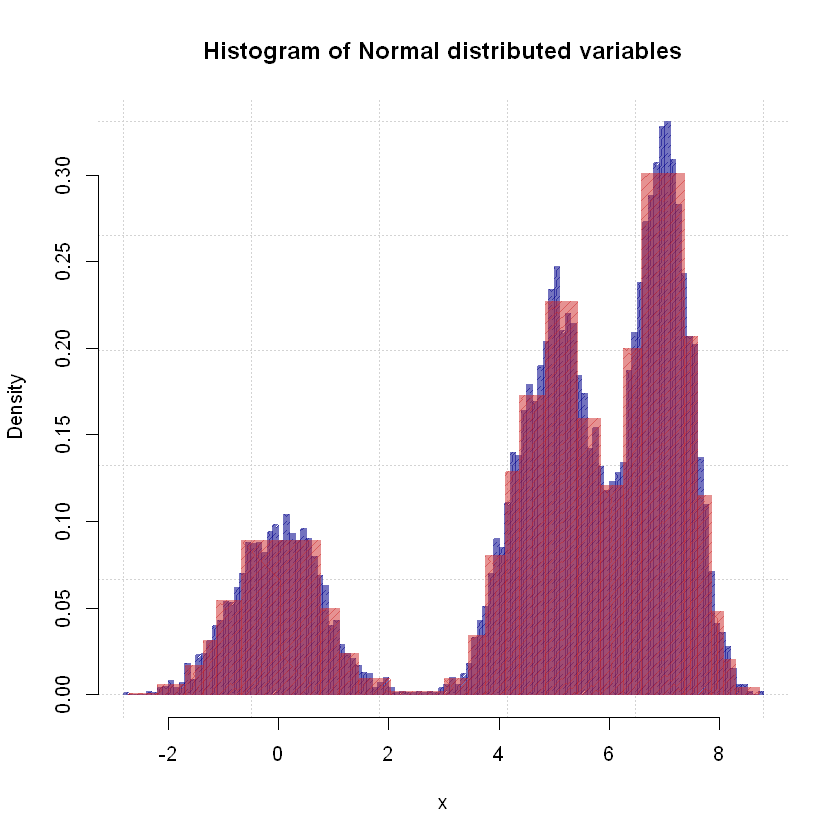

In [66]:
hist(norm_data,breaks=sqrt(N),freq=FALSE,col=scales::alpha('darkblue',.55),border=F, panel.first=grid(),density=200,
     xlab='x',ylab='Density',main=sprintf('Histogram of Normal distributed variables'))
hist(norm_data,breaks=breaks,density=200,
     freq=FALSE,col=scales::alpha('firebrick3',.5),border=F,add=T)